In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

In [20]:
symbol = 'IDFCFIRSTB.NS'
start_date = None # '2022-01-01'
end_date = None #'2022-11-14'

# period = "1mo"
# interval = "15m"

period = "2y"
interval = "1d"

def get_stock_price(symbol):
  df = yf.download(tickers=symbol, interval=interval, period=period, start=start_date, end=end_date)
  #df = yf.download(symbol, period="1mo", interval="15m")
  df['Date'] = pd.to_datetime(df.index)
  df['Date'] = df['Date'].apply(mpl_dates.date2num)
  df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  return df


df = get_stock_price(symbol)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close
Date,,,,,
2022-11-07,19303.0,57.250000,58.150002,56.849998,57.299999
2022-11-09,19305.0,57.299999,58.150002,57.150002,57.400002
2022-11-10,19306.0,57.400002,58.500000,57.200001,57.599998
2022-11-11,19307.0,58.299999,58.500000,57.450001,57.549999
2022-11-14,19310.0,57.750000,57.799999,57.049999,57.450001


1. Fractal candlestick pattern
There are actually a few ways to do it. In his amazingly helpful article, Giancula is using fractal candlestick pattern to detect the pivot points which then become the support or resistance levels.

Take 5 candles, if the candle in the middle has the highest high and the 2nd and 4th candle have lower highs, we have a bearish fractal or a resistance level. Vice versa for a bullish fractal.

In [22]:
#method 1: fractal candlestick pattern
# determine bullish fractal 
def is_support(df,i):  
  cond1 = df['Low'][i] < df['Low'][i-1]   
  cond2 = df['Low'][i] < df['Low'][i+1]   
  cond3 = df['Low'][i+1] < df['Low'][i+2]   
  cond4 = df['Low'][i-1] < df['Low'][i-2]  
  return (cond1 and cond2 and cond3 and cond4) 
# determine bearish fractal
def is_resistance(df,i):  
  cond1 = df['High'][i] > df['High'][i-1]   
  cond2 = df['High'][i] > df['High'][i+1]   
  cond3 = df['High'][i+1] > df['High'][i+2]   
  cond4 = df['High'][i-1] > df['High'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)
# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
  ave =  np.mean(df['High'] - df['Low'])    
  return np.sum([abs(value-level)<ave for _,level in levels])==0
# a list to store resistance and support levels
levels = []
for i in range(2, df.shape[0] - 2):  
  if is_support(df, i):    
    low = df['Low'][i]    
    if is_far_from_level(low, levels, df):      
      levels.append((i, low))  
  elif is_resistance(df, i):    
    high = df['High'][i]    
    if is_far_from_level(high, levels, df):      
      levels.append((i, high))

In [17]:
# for visualization
def plot_all(levels, df):    
  fig, ax = plt.subplots(figsize=(16, 9))   
  candlestick_ohlc(ax,df.values,width=0.6, colorup='green', colordown='red', alpha=0.8)    
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)    
  for level in levels:        
    plt.hlines(level[1], xmin = df['Date'][level[0]], xmax = max(df['Date']), colors='blue', linestyle='--')    
  fig.show()

C:\Users\Sachin\AppData\Local\Temp\2\ipykernel_6216\3201097211.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


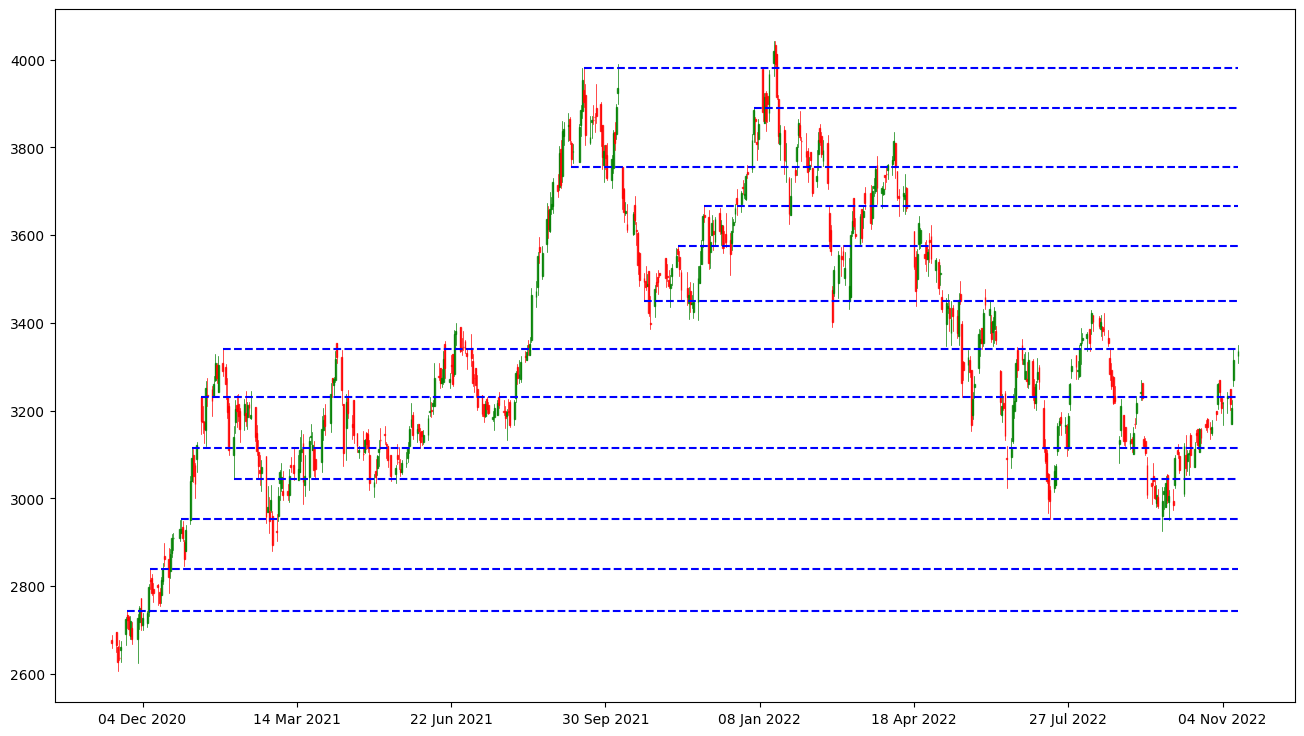

In [18]:
plot_all(levels, df)

2. Window shifting method
Another way is to use a simple window shifting method to determine pivot points.

Let’s look at the illustration below. First, we take a window of 9 candles (illustrated by the yellow box) and find the maximum of the candles within the window. Then, shift the window up a candle (the green box) and find the maximum of the candles within the window. Do the same until you have shifted 5 times. If the candle with the highest value remains the same throughout the steps, we have a pivot point.

C:\Users\Sachin\AppData\Local\Temp\2\ipykernel_6216\3201097211.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


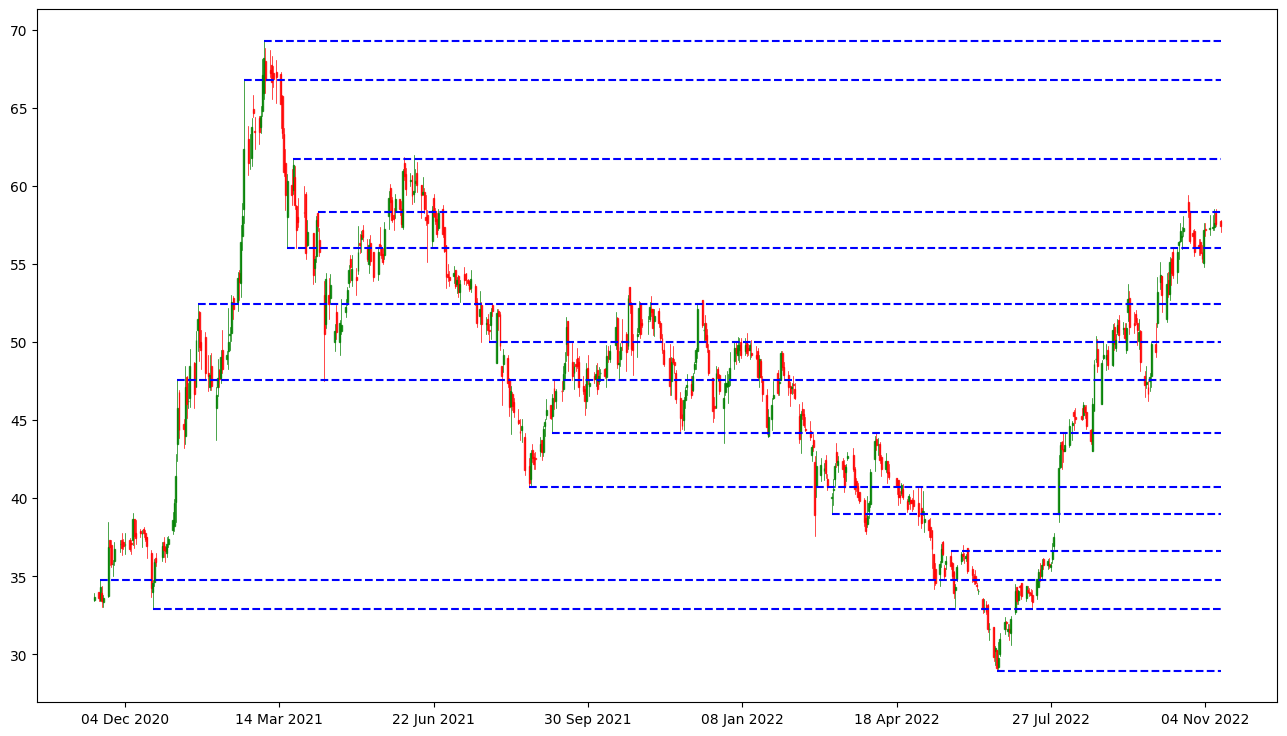

In [23]:
#method 2: window shifting method
#using the same symbol as the first example above
pivots = []
max_list = []
min_list = []
for i in range(5, len(df)-5):
  # taking a window of 9 candles
  high_range = df['High'][i-5:i+4]
  current_max = high_range.max()
  # if we find a new maximum value, empty the max_list 
  if current_max not in max_list:
    max_list = []
  max_list.append(current_max)
  # if the maximum value remains the same after shifting 5 times
  if len(max_list)==5 and is_far_from_level(current_max,levels,df):
      levels.append((high_range.idxmax(), current_max))
    
  low_range = df['Low'][i-5:i+5]
  current_min = low_range.min()
  if current_min not in min_list:
    min_list = []
  min_list.append(current_min)
  if len(min_list)==5 and is_far_from_level(current_min,levels,df):
    levels.append((low_range.idxmin(), current_min))
plot_all(levels, df)

In [29]:
# get the full stock list of S&P 500 
payload=pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')
# # get the full stock list of S&P 500 
# payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# stock_list = payload[0]['Symbol'].values.tolist()

In [32]:

stock_list = payload[1]['Symbol'].values.tolist()
stock_list = [f"{x}.NS" for x in stock_list]
print(stock_list)

['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BHARTIARTL.NS', 'BPCL.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFC.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS', 'ITC.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS', 'M&M.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'NTPC.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBIN.NS', 'SBILIFE.NS', 'SUNPHARMA.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TCS.NS', 'TATACONSUM.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'UPL.NS', 'WIPRO.NS']


In [34]:
#method 1: fractal candlestick pattern
def detect_level_method_1(df):
  levels = []
  for i in range(2,df.shape[0]-2):
    if is_support(df,i):
      l = df['Low'][i]
      if is_far_from_level(l, levels, df):
        levels.append((i,l))
    elif is_resistance(df,i):
      l = df['High'][i]
      if is_far_from_level(l, levels, df):
        levels.append((i,l))
  return levels

#method 2: window shifting method
def detect_level_method_2(df):
  levels = []
  max_list = []
  min_list = []
  for i in range(5, len(df)-5):
      high_range = df['High'][i-5:i+4]
      current_max = high_range.max()
      if current_max not in max_list:
          max_list = []
      max_list.append(current_max)
      if len(max_list) == 5 and is_far_from_level(current_max, levels, df):
          levels.append((high_range.idxmax(), current_max))
      
      low_range = df['Low'][i-5:i+5]
      current_min = low_range.min()
      if current_min not in min_list:
          min_list = []
      min_list.append(current_min)
      if len(min_list) == 5 and is_far_from_level(current_min, levels, df):
          levels.append((low_range.idxmin(), current_min))
  return levels

# to detect breakout
def has_breakout(levels, previous, last):
  for _, level in levels:
    cond1 = (previous['Open'] < level) 
    #cond2 = (last['Open'] > level) and (last['Low'] > level)
    cond2 = (last['Close'] > level)
  return (cond1 and cond2)

# lists to store the screened results
screened_list_1 = [] 
screened_list_2 = []

# loop through each symbol
for symbol in stock_list:
  try: 
    df = get_stock_price(symbol)
    
    # get levels using the first method
    levels_1 = detect_level_method_1(df)
    if (has_breakout(levels_1[-5:], df.iloc[-2], df.iloc[-1])):
      screened_list_1.append(symbol)

    # get levels using the second method
    levels_2 = detect_level_method_2(df)
    if (has_breakout(levels_2[-5:], df.iloc[-2], df.iloc[-1])):
      screened_list_2.append(symbol)

  except Exception as e:
    print(e)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********